In [44]:
# Importaciones básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import os
from tqdm import tqdm

# Importaciones de darts
from darts import TimeSeries

# Importar el StandardScaler() para normalizar los datos de un pandas dataframe
from sklearn.preprocessing import StandardScaler

# Métricas de scikit-learn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Para optimización de hiperparámetros
import optuna

# TimesFM y sus dependencias
import timesfm
# from timesfm.timesfm_torch import TimesFmTorch as TimesFM # Asegúrate de tener instalado timesfm
# from timesfm.timesfm_base import TimesFmHparams, TimesFmCheckpoint


# Configuración de logging
import logging

logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

In [45]:
# Cargar datos
df = pd.read_csv("monthly_data.csv")
df["DATES"] = pd.to_datetime(df["DATES"])
df.set_index("DATES", inplace=True)

df = df.dropna()
df.head(), df.tail()

(              PEN
 DATES            
 1994-12-31  2.185
 1995-01-31  2.194
 1995-02-28  2.237
 1995-03-31  2.258
 1995-04-30  2.245,
                PEN
 DATES             
 2024-04-30  3.7664
 2024-05-31  3.7245
 2024-06-30  3.8425
 2024-07-31  3.7283
 2024-08-31  3.7493)

In [46]:
# Preprocesamiento de datos son pandas
series = df[["PEN"]]
train_size = int(len(series) * 0.8)
train_data, test_data = series[:train_size], series[train_size:]

In [77]:
# Funciones auxiliares que necesitaremos
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2}


def save_hyperparameters(params, model_name):
    filename = f"best_hyperparameters_{model_name}.json"
    with open(filename, "w") as f:
        json.dump(params, f)
    print(f"Hiperparámetros guardados en {filename}")


def load_hyperparameters(model_name):
    filename = f"best_hyperparameters_{model_name}.json"
    try:
        with open(filename, "r") as f:
            return json.load(f)
    except FileNotFoundError:
        return None


def save_model(model, model_name):
    filename = f"{model_name}_model.pkl"
    with open(filename, "wb") as f:
        pickle.dump(model, f)
    print(f"Modelo guardado en {filename}")


def load_model(model_name):
    filename = f"{model_name}_model.pkl"
    try:
        with open(filename, "rb") as f:
            return pickle.load(f)
    except FileNotFoundError:
        return None


# Funciones para la estrategia de trading


# Transform the serie en returns
def return_series(series):
    if not isinstance(series, pd.Series):
        raise TypeError(
            "La serie debe ser un objeto de tipo pandas.Series para calcular los retornos."
        )
    return series.pct_change().dropna()


def implement_trading_strategy(real_returns, predicted_returns):
    if isinstance(real_returns, np.ndarray):
        real_returns_pd = pd.Series(real_returns)
    elif isinstance(real_returns, pd.Series):
        real_returns_pd = real_returns
    else:
        raise ValueError("real_returns must be either numpy array or pandas Series.")

    if isinstance(predicted_returns, np.ndarray):
        predicted_returns_pd = pd.Series(predicted_returns)
    elif isinstance(predicted_returns, pd.Series):
        predicted_returns_pd = predicted_returns
    else:
        raise ValueError(
            "predicted_returns must be either numpy array or pandas Series."
        )

    # Create the position and calculate strategy returns
    position = pd.Series(
        np.where(predicted_returns_pd > 0, 1, -1), index=predicted_returns_pd.index
    )
    strategy_returns = real_returns_pd * position.shift(1)

    return strategy_returns


def calculate_cumulative_return(returns):
    return (1 + returns).cumprod() - 1


def calculate_performance_metrics(pred_returns, benchmark_returns=None):
    # Asegurar que los inputs sean pandas.Series
    if not isinstance(pred_returns, pd.Series):
        pred_returns = pd.Series(pred_returns)

    # Crear un benchmark de ceros si no se proporciona uno
    if benchmark_returns is None:
        benchmark_returns = pd.Series([0] * len(pred_returns), index=pred_returns.index)
    elif not isinstance(benchmark_returns, pd.Series):
        benchmark_returns = pd.Series(benchmark_returns)

    # Retornos totales y anualizados
    total_return = (1 + pred_returns).prod() - 1
    annualized_return = (1 + total_return) ** (12 / len(pred_returns)) - 1

    # Sharpe Ratio (sin tasa libre de riesgo)
    sharpe_ratio = np.sqrt(12) * pred_returns.mean() / pred_returns.std()

    # Exceso de retornos para Information Ratio
    excess_returns = pred_returns - benchmark_returns
    tracking_error = excess_returns.std()
    information_ratio = excess_returns.mean() / tracking_error

    # Máximo Drawdown
    cumulative_returns = (1 + pred_returns).cumprod()
    peak = cumulative_returns.cummax()
    max_drawdown = ((cumulative_returns / peak) - 1).min()

    return {
        "Total Return": total_return,
        "Annualized Return": annualized_return,
        "Sharpe Ratio": sharpe_ratio,
        "Information Ratio": information_ratio,
        "Max Drawdown": max_drawdown,
    }


def calculate_hit_ratio(y_pred, y_true=None):
    """
    Calcula el Hit Ratio entre los valores reales y predichos.

    :param y_true: Array o Series con los valores reales, usa y_pred como y_true si no se proporciona
    :param y_pred: Array o Series con los valores predichos
    :return: Tupla con (hit_ratio, hit_ratio_string)

    Si y_true no se proporciona, se calculará el hit ratio de y_pred contra sí mismo.
    """
    if y_true is None:
        y_true = y_pred
    if isinstance(y_true, pd.Series):
        y_true = y_true.to_numpy()
    if isinstance(y_pred, pd.Series):
        y_pred = y_pred.to_numpy()

    if len(y_pred) != len(y_true):
        raise ValueError("y_pred and y_true must have the same length.")

    same_sign_count = np.sum(np.sign(y_pred) == np.sign(y_true))
    hit_ratio = same_sign_count / len(y_true) * 100

    hit_ratio_string = f"Hit Ratio = {hit_ratio:.2f}%"

    return hit_ratio, hit_ratio_string


# Función para calcular todas las métricas incluyendo Hit Ratio
def calculate_all_metrics(pred_returns, real_returns=None):
    performance_metrics = calculate_performance_metrics(pred_returns, real_returns)
    hit_ratio, hit_ratio_string = calculate_hit_ratio(pred_returns, real_returns)

    all_metrics = {
        **performance_metrics,
        "Hit Ratio": hit_ratio,
    }

    return all_metrics


def evaluate_model_performance(y_true, y_pred, model_name, retrain=False):
    # Handle Darts TimeSeries objects
    if isinstance(y_true, TimeSeries):
        y_true = y_true.values()  # Convert to NumPy array
    if isinstance(y_pred, TimeSeries):
        y_pred = y_pred.values()  # Convert to NumPy array

    # Ensure y_true and y_pred are numpy arrays or pandas Series
    if not isinstance(y_true, (np.ndarray, pd.Series)):
        raise TypeError(
            f"y_true debe ser un numpy.ndarray, pandas.Series o Darts TimeSeries, pero se recibió {type(y_true)}"
        )
    if not isinstance(y_pred, (np.ndarray, pd.Series)):
        raise TypeError(
            f"y_pred debe ser un numpy.ndarray, pandas.Series o Darts TimeSeries, pero se recibió {type(y_pred)}"
        )

    # Convert to numpy array if it's a pandas Series
    y_true_np = y_true.values if isinstance(y_true, pd.Series) else y_true
    y_pred_np = y_pred.values if isinstance(y_pred, pd.Series) else y_pred

    # Error metrics calculation
    mse = mean_squared_error(y_true_np, y_pred_np)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_np, y_pred_np)
    r2 = r2_score(y_true_np, y_pred_np)

    error_metrics = {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2}

    # Convert to pandas Series for return calculations
    y_true_series = (
        pd.Series(y_true.flatten()) if isinstance(y_true, np.ndarray) else y_true
    )
    y_pred_series = (
        pd.Series(y_pred.flatten()) if isinstance(y_pred, np.ndarray) else y_pred
    )

    # Ensure they are Series before calculating returns
    try:
        y_true_returns = return_series(y_true_series)
        y_pred_returns = return_series(y_pred_series)
    except TypeError as e:
        print(f"Error: {e}")
        return None, None

    # Implement trading strategy
    strategy_returns = implement_trading_strategy(y_true_returns, y_pred_returns)

    # Calculate performance metrics
    performance_metrics = calculate_performance_metrics(
        strategy_returns, y_true_returns
    )

    # Calculate Hit Ratio
    hit_ratio, hit_ratio_string = calculate_hit_ratio(strategy_returns, y_true_returns)

    # Combine all metrics
    all_metrics = {
        "Model": model_name,
        "Retrain": retrain,
        **error_metrics,
        **performance_metrics,
        "Hit Ratio": hit_ratio,
    }

    return all_metrics, strategy_returns

# MODELO TIMESFM

In [ ]:
def optimize_timesfm(train_df):
    def objective(trial):
        params = {
            "context_len": trial.suggest_int("context_len", 32, 256, step=32),
            "per_core_batch_size": trial.suggest_categorical(
                "per_core_batch_size", [16, 32, 64, 128]
            ),
        }

        try:
            model = timesfm.TimesFm(
                hparams=timesfm.TimesFmHparams(
                    context_len=params["context_len"],
                    horizon_len=1,
                    per_core_batch_size=params["per_core_batch_size"],
                    backend="gpu",
                ),
                checkpoint=timesfm.TimesFmCheckpoint(
                    huggingface_repo_id="google/timesfm-1.0-200m-pytorch"
                ),
            )

            # Usar una porción de los datos para validación
            val_size = int(len(train_df) * 0.2)
            train_subset = train_df.iloc[:-val_size].copy()
            val_subset = train_df.iloc[-val_size:].copy()

            # Asegurarnos de que tenemos suficientes datos para el contexto
            if len(train_subset) < params["context_len"]:
                return float("inf")

            # Realizar predicción
            forecast_df = model.forecast_on_df(
                inputs=train_subset,
                freq="M",  # Frecuencia mensual
                value_name="y",
                num_jobs=-1,
                forecast_context_len=min(params["context_len"], len(train_subset)),
            )

            if len(forecast_df) == 0:
                return float("inf")

            # Calcular error solo para el primer paso de predicción
            val_actual = val_subset["y"].iloc[0]
            forecast_value = forecast_df["timesfm"].iloc[0]

            error = abs(val_actual - forecast_value)
            return error

        except Exception as e:
            print(f"Error durante la optimización: {str(e)}")
            return float("inf")

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50)

    return study.best_params

In [ ]:
def train_timesfm(train_data):
    # Escalar los datos
    scaler = StandardScaler()
    train_scaled = pd.DataFrame(
        scaler.fit_transform(train_data[["PEN"]]),
        index=train_data.index,
        columns=["PEN"],
    )

    # Preparar DataFrame en el formato requerido
    train_df = pd.DataFrame(
        {
            "unique_id": ["USDPEN"] * len(train_scaled),
            "ds": train_scaled.index,
            "y": train_scaled["PEN"],
        }
    )

    # Cargar o encontrar los mejores hiperparámetros
    loaded_params = load_hyperparameters("timesfm")
    if loaded_params is None:
        print("Optimizando hiperparámetros para TimesFM...")
        best_params = optimize_timesfm(train_df)
        save_hyperparameters(best_params, "timesfm")
    else:
        print("Cargando hiperparámetros guardados para TimesFM...")
        best_params = loaded_params

    # Crear modelo con los mejores parámetros
    model = timesfm.TimesFm(
        hparams=timesfm.TimesFmHparams(
            context_len=best_params.get("context_len", 128),
            horizon_len=1,
            per_core_batch_size=best_params.get("per_core_batch_size", 32),
            backend="gpu",
        ),
        checkpoint=timesfm.TimesFmCheckpoint(
            huggingface_repo_id="google/timesfm-1.0-200m-pytorch"
        ),
    )

    return model, train_df, scaler

In [55]:
def timesfm_step_by_step_forecast(
    model, train_df, test_data, scaler, retrain=False, progress_bar=None
):
    forecast_filename = f"timesfm_forecast_{'retrain' if retrain else 'no_retrain'}.pkl"

    if os.path.exists(forecast_filename):
        print(f"Cargando forecast guardado de {forecast_filename}")
        with open(forecast_filename, "rb") as f:
            return pickle.load(f)

    predictions = []
    current_df = train_df.copy()

    # Escalar datos de prueba
    test_scaled = pd.DataFrame(
        scaler.transform(test_data[["PEN"]]), index=test_data.index, columns=["PEN"]
    )

    # Guardar la configuración inicial del modelo
    model_config = {
        "context_len": model.context_len,
        "horizon_len": model.horizon_len,
        "per_core_batch_size": model.per_core_batch_size,
        "backend": model.backend,
    }

    for i in tqdm(range(len(test_scaled)), desc="Generando predicciones"):
        try:
            # Realizar predicción usando forecast_on_df
            forecast_df = model.forecast_on_df(
                inputs=current_df,
                freq="M",
                value_name="y",
                num_jobs=-1,
                forecast_context_len=min(model.context_len, len(current_df)),
            )

            if len(forecast_df) > 0:
                pred_scaled = forecast_df["timesfm"].iloc[0]
                pred_unscaled = scaler.inverse_transform([[pred_scaled]])[0][0]
            else:
                pred_unscaled = np.nan

            predictions.append(pred_unscaled)

            # Actualizar DataFrame con el nuevo punto
            new_point = pd.DataFrame(
                {
                    "unique_id": ["USDPEN"],
                    "ds": [test_scaled.index[i]],
                    "y": [test_scaled["PEN"].iloc[i]],
                }
            )
            current_df = pd.concat([current_df, new_point], ignore_index=True)

            if retrain and i < len(test_scaled) - 1:
                # Crear una nueva instancia del modelo con la misma configuración
                model = timesfm.TimesFm(
                    hparams=timesfm.TimesFmHparams(**model_config),
                    checkpoint=timesfm.TimesFmCheckpoint(
                        huggingface_repo_id="google/timesfm-1.0-200m-pytorch"
                    ),
                )

        except Exception as e:
            print(f"Error en la predicción {i}: {str(e)}")
            predictions.append(np.nan)

        if progress_bar:
            progress_bar.update(100 // len(test_data))

    # Asegurarnos de que tenemos el mismo número de predicciones que fechas de test
    predictions = np.array(predictions)
    if len(predictions) > len(test_data):
        predictions = predictions[: len(test_data)]
    elif len(predictions) < len(test_data):
        # Rellenar con NaN si faltan predicciones
        pad_length = len(test_data) - len(predictions)
        predictions = np.pad(
            predictions, (0, pad_length), "constant", constant_values=np.nan
        )

    # Crear TimeSeries con las predicciones
    try:
        forecast = TimeSeries.from_dataframe(
            pd.DataFrame(
                predictions.reshape(-1, 1), index=test_data.index, columns=["PEN"]
            )
        )
    except ValueError as e:
        print(f"Error al crear TimeSeries: {str(e)}")
        print(
            f"Dimensiones - predicciones: {predictions.shape}, fechas: {len(test_data.index)}"
        )
        raise e

    print(f"Guardando forecast en {forecast_filename}")
    with open(forecast_filename, "wb") as f:
        pickle.dump(forecast, f)

    return forecast

In [56]:
# Entrenar el modelo

timesfm_model, train_df, scaler = train_timesfm(train_data)

Cargando hiperparámetros guardados para TimesFM...


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

In [62]:
# Realizar predicciones
timesfm_forecast_no_retrain = timesfm_step_by_step_forecast(
    timesfm_model, train_df, test_data, scaler, retrain=False
)

timesfm_forecast_with_retrain = timesfm_step_by_step_forecast(
    timesfm_model, train_df, test_data, scaler, retrain=True
)

Cargando forecast guardado de timesfm_forecast_no_retrain.pkl
Cargando forecast guardado de timesfm_forecast_retrain.pkl


In [ ]:
# Calcular métricas
y_true = test_data["PEN"].values
y_pred_no_retrain = timesfm_forecast_no_retrain.values().flatten()
y_pred_with_retrain = timesfm_forecast_with_retrain.values().flatten()

In [80]:
timesfm_evaluation_no_retrain = evaluate_model(y_true, y_pred_no_retrain)
timesfm_evaluation_with_retrain = evaluate_model(y_true, y_pred_with_retrain)

print("Evaluación del modelo TiDE sin reentrenamiento:")
for metric, value in timesfm_evaluation_no_retrain.items():
    print(f"{metric}: {value:.6f}")

print("\nEvaluación del modelo TiDE con reentrenamiento:")
for metric, value in timesfm_evaluation_with_retrain.items():
    print(f"{metric}: {value:.6f}")

Evaluación del modelo TiDE sin reentrenamiento:
MSE: 0.006088
RMSE: 0.078025
MAE: 0.064336
R2: 0.884166

Evaluación del modelo TiDE con reentrenamiento:
MSE: 0.006088
RMSE: 0.078025
MAE: 0.064336
R2: 0.884166


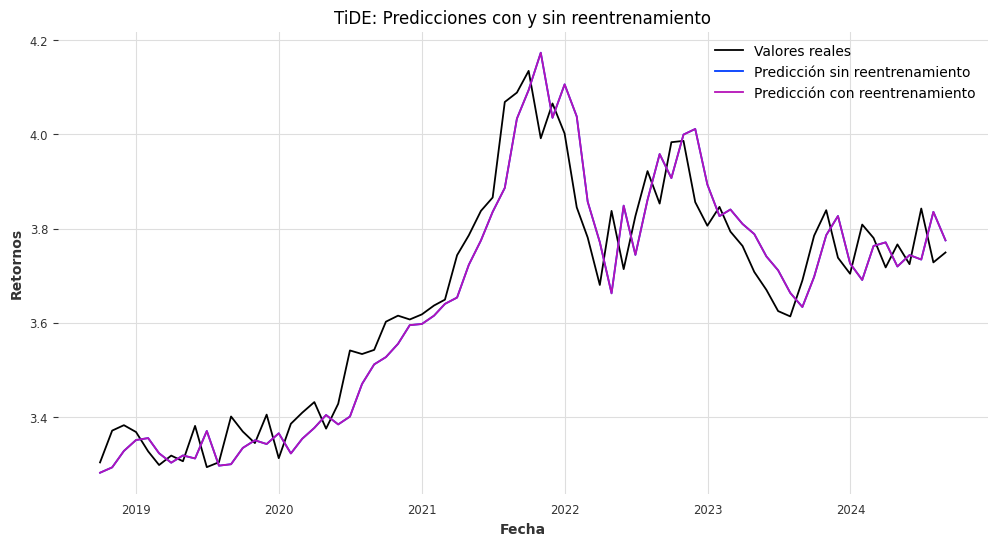

In [ ]:
# Visualizar resultados
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, y_true, label="Valores reales")
plt.plot(test_data.index, y_pred_no_retrain, label="Predicción sin reentrenamiento")
plt.plot(test_data.index, y_pred_with_retrain, label="Predicción con reentrenamiento")
plt.legend()
plt.title("TimesFM: Predicciones con y sin reentrenamiento")
plt.xlabel("Fecha")
plt.ylabel("Retornos")
plt.show()

In [71]:
type(test_data)

pandas.core.frame.DataFrame

In [73]:
# Implementar estrategia de trading para ambos casos
real_returns = return_series(test_data.PEN)
pred_returns_no_retrain = return_series(timesfm_forecast_no_retrain.pd_series())
pred_returns_with_retrain = return_series(timesfm_forecast_with_retrain.pd_series())

In [74]:
# Implementar estrategia de trading para ambos casos
strategy_returns_no_retrain = implement_trading_strategy(
    real_returns, pred_returns_no_retrain
)
strategy_returns_with_retrain = implement_trading_strategy(
    real_returns, pred_returns_with_retrain
)

In [75]:
# Calcular retornos acumulados
cumulative_real = calculate_cumulative_return(real_returns)
cumulative_strategy_no_retrain = calculate_cumulative_return(
    strategy_returns_no_retrain
)
cumulative_strategy_with_retrain = calculate_cumulative_return(
    strategy_returns_with_retrain
)

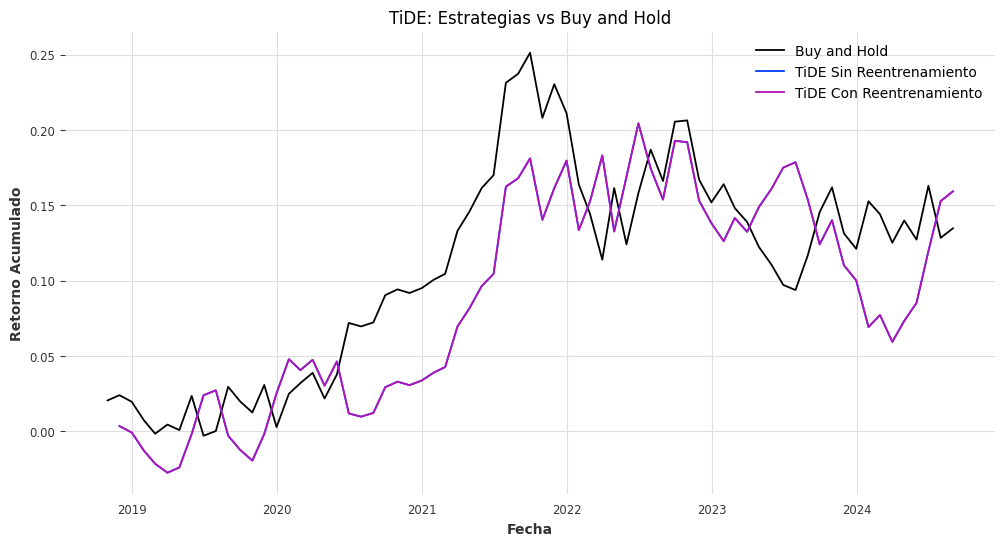

In [76]:
# Visualizar resultados de la estrategia
plt.figure(figsize=(12, 6))
plt.plot(cumulative_real.index, cumulative_real, label="Buy and Hold")
plt.plot(
    cumulative_strategy_no_retrain.index,
    cumulative_strategy_no_retrain,
    label="TiDE Sin Reentrenamiento",
)
plt.plot(
    cumulative_strategy_with_retrain.index,
    cumulative_strategy_with_retrain,
    label="TiDE Con Reentrenamiento",
)
plt.legend()
plt.title("TiDE: Estrategias vs Buy and Hold")
plt.xlabel("Fecha")
plt.ylabel("Retorno Acumulado")
plt.show()

In [79]:
# Calcular métricas de rendimiento para ambas estrategias
metrics_buy_hold = calculate_all_metrics(real_returns)
metrics_strategy_no_retrain = calculate_all_metrics(
    strategy_returns_no_retrain, real_returns
)
metrics_strategy_with_retrain = calculate_all_metrics(
    strategy_returns_with_retrain, real_returns
)

print("\nMétricas de rendimiento:")
print("\nBuy and Hold:")
for k, v in metrics_buy_hold.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")
print("\nEstrategia TimesFM sin reentrenamiento:")
for k, v in metrics_strategy_no_retrain.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")
print("\nEstrategia TimesFM con reentrenamiento:")
for k, v in metrics_strategy_with_retrain.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")


Métricas de rendimiento:

Buy and Hold:
Total Return: 0.1348
Annualized Return: 0.0216
Sharpe Ratio: 0.3437
Information Ratio: 0.0992
Max Drawdown: -0.1260
Hit Ratio: 100.0000

Estrategia TimesFM sin reentrenamiento:
Total Return: 0.1593
Annualized Return: 0.0253
Sharpe Ratio: 0.4022
Information Ratio: 0.0227
Max Drawdown: -0.1205
Hit Ratio: 61.9718

Estrategia TimesFM con reentrenamiento:
Total Return: 0.1593
Annualized Return: 0.0253
Sharpe Ratio: 0.4022
Information Ratio: 0.0227
Max Drawdown: -0.1205
Hit Ratio: 61.9718
